In [0]:
# Filtado de mensajes spam

## Descripción del problema real

La recepción de publicidad no deseada a traves mensajes de texto usando SMS (Short Message Service) es un problema que afecta a muchos usuarios de teléfonos móviles. El problema radica en que los usuarios deben pagar por los mesajes recibidos, y por este motivo resulta muy importante que las compañías prestadoras del servicio puedan filtrar mensajes indeseados antes de enviarlos a su destinatario final. Los mensajes tienen una longitud máxima de 160 caracteres, por lo que el texto resulta poco para realizar la clasificación, en comparación con textos más largos (como los emails). Adicionalmente, los errores de digitación dificultan el proceso de detección automática.

## Descripción del problema en términos de los datos

Se tiene una muestra contiene 5574 mensajes en inglés, no codificados y clasificados como legítimos (ham) o spam (http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/). La información está almacenada en el archivo `datos/spam-sms.zip`.El problema en términos de los datos consiste en clasificar si un mensaje SMS es legítico o spam, a partir del análisis de las palabras que contiente, partiendo del supuesto de que ciertas palabras que son más frecuentes dependiendo del tipo de mensaje. Esto implica que en la fase de preparación de los datos se deben extraer las palabras que contiene cada mensaje para poder realizar el análsis.

## Aproximaciones posibles

En este caso, se desea comparar los resultados de un modelo de redes neuronales artificiales y otras técnicas estadísticas para realizar la clasificación.

## Requerimientos

Usted debe:

* Preprocesar los datos para representarlos usando bag-of-words.


* Construir un modelo de regresión logística como punto base para la comparación con otros modelos más complejos.


* Construir un modelo de redes neuronales artificiales. Asimismo, debe determinar el número de neuronas en la capa o capas ocultas.


* Utiizar una técnica como crossvalidation u otra similar para establecer la robustez del modelo.


* Presentar métricas de desempeño para establecer las bondades y falencias de cada clasificador.

# Preparación

In [117]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem.porter import PorterStemmer


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier

from plotnine import *

%matplotlib inline
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# Carga de datos

In [118]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/jdvelasq/datalabs/master/datasets/sms-spam.csv",
    sep = ',',
    thousands = None,
    decimal = '.',
    encoding='latin-1')

df.head()

,type,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [119]:

##
## Verifica la lectura de los datos
##
df.describe()

,type,text
count,5574,5574
unique,2,5160
top,ham,"Sorry, I'll call later"
freq,4827,30


# Conteo de cantidad de mensaje por tipos

In [120]:
## Se obtiene la cantidad de casos para
## cada tipo de mensaje.
##
df.type.value_counts()

ham     4827
spam     747
Name: type, dtype: int64

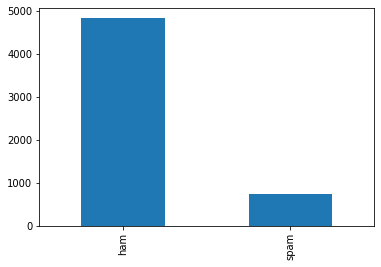

In [121]:

df.type.value_counts().plot.bar();

# Stemmer

In [122]:
stemmer = PorterStemmer()

df['stemmed'] = df.text.apply(lambda x: ' '.join([stemmer.stem(w) for w in x.split() ]))

df.head(10)

,type,text,stemmed
0,ham,"Go until jurong point, crazy.. Available only ...","Go until jurong point, crazy.. avail onli in b..."
1,ham,Ok lar... Joking wif u oni...,Ok lar... joke wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri in 2 a wkli comp to win FA cup fina...
3,ham,U dun say so early hor... U c already then say...,U dun say so earli hor... U c alreadi then say...
4,ham,"Nah I don't think he goes to usf, he lives aro...","nah I don't think he goe to usf, he live aroun..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...,freemsg hey there darl it' been 3 week' now an...
6,ham,Even my brother is not like to speak with me. ...,even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...,As per your request 'mell mell (oru minnaminun...
8,spam,WINNER!! As a valued network customer you have...,winner!! As a valu network custom you have bee...
9,spam,Had your mobile 11 months or more? U R entitle...,had your mobil 11 month or more? U R entitl to...


# Matriz de términos del documento

In [123]:
##
## Matriz de términos del documento en Python
##
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(
    analyzer='word',        # a nivel de palabra
    lowercase=True,         # convierte a minúsculas
    stop_words='english',   # stop_words en inglés
    binary=True,            # Los valores distintos de cero son fijados en 1
    min_df=5                # ignora palabras con baja freq
)


##
## Aplica la función al texto
##
dtm = count_vect.fit_transform(df.stemmed)

##
## Las filas contienen los mensajes
## y las clomunas los términos
##
dtm.shape

(5574, 1540)

In [124]:
##
## Palabras aprendidas de los mensajes de texto
##
vocabulary = count_vect.get_feature_names()
len(vocabulary)

1540

In [125]:
##
## Primeras palabras del vocabulario
##
vocabulary[0:10]

['00',
 '000',
 '02',
 '03',
 '04',
 '06',
 '0800',
 '08000839402',
 '08000930705',
 '0870']

In [126]:
##
## Recupera los mensajes de la dtm
##
def dtm2words(dtm, vocabulary, index):
    as_list = dtm[index,:].toarray().tolist()
    docs = []
    for i in index:
        k = [vocabulary[iword] for iword, ifreq in enumerate(as_list[i]) if ifreq > 0]
        docs += [k]
    return docs

for i, x in enumerate(dtm2words(dtm, vocabulary, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])):
    print('Org: ', df.text[i])
    print('Mod: ', ' '.join(x))
    print('')

Org:  Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Mod:  avail bugi cine got great la onli point wat world

Org:  Ok lar... Joking wif u oni...
Mod:  joke lar ok wif

Org:  Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
Mod:  appli comp cup entri final free question rate receiv std text txt win wkli

Org:  U dun say so early hor... U c already then say...
Mod:  alreadi dun earli say

Org:  Nah I don't think he goes to usf, he lives around here though
Mod:  don goe live nah think usf

Org:  FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, Â£1.50 to rcv
Mod:  50 darl freemsg fun hey like ok send std week word xxx

Org:  Even my brother is not like to speak with me. They treat me like aids patent.
Mod:  brother like speak treat

Or

# Conjuntos de entrenamiento y prueba

In [0]:
##
## Creación de los conjuntos de entrenamiento y prueba.
##
X_train      = dtm[0:4168,]
X_validacion       = dtm[4169:,]
y_train= df.type[0:4168]
y_validacion  = df.type[4169:]

# Entrenamiento de modelos de regresión logística

In [0]:
logisticRegression1 = LogisticRegression(
    penalty='none',            # ‘l1’, ‘l2’, ‘elasticnet’, ‘none’
    tol=0.0001,              # stop criteria
    C=1.0,                   # factor inverso para regularizacion (SVM)
    fit_intercept=True,      #
    class_weight=None,       # None, dict or ‘balanced’
    random_state=None,       #
    solver='sag',           # 'newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’
    max_iter=5000,            #
    multi_class='auto',      # ‘ovr’, ‘multinomial’, ‘auto’
    verbose=0,               #
    warm_start=False,        # ?re-usa la solución previa
    l1_ratio=None            # Elastic-Net mixing parameter, with 0 <= l1_ratio <= 1
)

logisticRegression2 = LogisticRegression(
    penalty='l2',            # ‘l1’, ‘l2’, ‘elasticnet’, ‘none’
    tol=0.0001,              # stop criteria
    C=1.0,                   # factor inverso para regularizacion (SVM)
    fit_intercept=True,      #
    class_weight=None,       # None, dict or ‘balanced’
    random_state=None,       #
    solver='lbfgs',           # 'newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’
    max_iter=100,            #
    multi_class='auto',      # ‘ovr’, ‘multinomial’, ‘auto’
    verbose=0,               #
    warm_start=False,        # ?re-usa la solución previa
    l1_ratio=None            # Elastic-Net mixing parameter, with 0 <= l1_ratio <= 1
)

logisticRegression1.fit(X_train.toarray(), y_train)
y_test_pred1 = logisticRegression1.predict(X_validacion.toarray())

logisticRegression2.fit(X_train.toarray(), y_train)
y_test_pred2 = logisticRegression2.predict(X_validacion.toarray())

# Evaluación de los modelos de regresión logística

Primer modelo de regresión logística: 

Accuracy Score : 0.9750889679715302
Report : 
              precision    recall  f1-score   support

         ham       0.98      0.99      0.99      1222
        spam       0.92      0.89      0.90       183

    accuracy                           0.98      1405
   macro avg       0.95      0.94      0.94      1405
weighted avg       0.97      0.98      0.97      1405



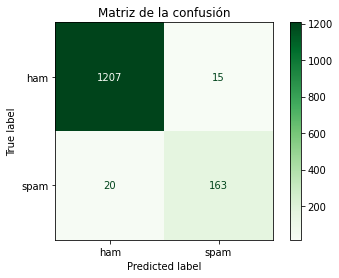

In [130]:
disp = plot_confusion_matrix(logisticRegression1, X_validacion.toarray(), y_validacion,
                              display_labels=['ham','spam'],
                              cmap=plt.cm.Greens,
                              normalize=None, 
                              values_format = '.0f')
disp.ax_.set_title('Matriz de la confusión')

print("Primer modelo de regresión logística: \n")
print ('Accuracy Score :',accuracy_score(y_validacion, y_test_pred1)) 
print ('Report : ')
print (classification_report(y_validacion, y_test_pred1)) 

Segundo modelo de regresión logística: 

Accuracy Score : 0.9807829181494662
Report : 
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1222
        spam       0.99      0.86      0.92       183

    accuracy                           0.98      1405
   macro avg       0.99      0.93      0.95      1405
weighted avg       0.98      0.98      0.98      1405



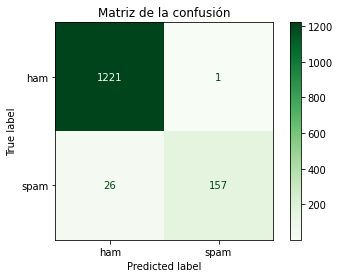

In [131]:
disp = plot_confusion_matrix(logisticRegression2, X_validacion.toarray(), y_validacion,
                              display_labels=['ham','spam'],
                              cmap=plt.cm.Greens,
                              normalize=None, 
                              values_format = '.0f')
disp.ax_.set_title('Matriz de la confusión')

print("Segundo modelo de regresión logística: \n")
print ('Accuracy Score :',accuracy_score(y_validacion, y_test_pred2)) 
print ('Report : ')
print (classification_report(y_validacion, y_test_pred2)) 

En el primer modelo planteado se le da más importancia al recall de spam para que este sea mayor, con este modelo se intenta minimizar que le lleguen mensajes al usuario que sean spam, con el riesgo de que puede evitar que le lleguen mensajes que no eran spam.

En cambio en el segundo modelo se le da más importancia a que le lleguen al usuario la mayor cantidad de mensajes que no son spam, teniendo como contra que puede dejar pasar una mayor cantidad de spam que el primer modelo.

# Modelos de redes neuronales


In [0]:
kfold = KFold(5, True, 1)

score_training = []
score_testing = []

for i in range(1,4):
  m = MLPClassifier(activation='relu', 
                    hidden_layer_sizes=(i,), 
                    random_state=1, 
                    shuffle=True,
                    warm_start=True,
                    max_iter=10000)
  score_train = 0
  score_test = 0

  for train, test in kfold.split(X_train):
    X_tr = X_train[train]
    y_tr = y_train[train]
    X_te = X_train[test]
    y_te = y_train[test]

    m.fit(X_tr,y_tr)
    score_train += m.score(X_tr, y_tr)
    score_test += m.score(X_te, y_te)
  score_training.append(score_train/5)
  score_testing.append(score_test/5)
    
    

In [148]:
numero_neuronas = list(range(1,4))
df2 = pd.DataFrame()
df2.insert(0,"Neuronas capa oculta", numero_neuronas, 2)
df2.insert(1,"Entrenamiento", score_training, 2)
df2.insert(2,"Prueba", score_testing, 2)
df2

,Neuronas capa oculta,Entrenamiento,Prueba
0,1,0.997061,0.996881
1,2,0.997541,0.996881
2,3,0.996881,0.995682


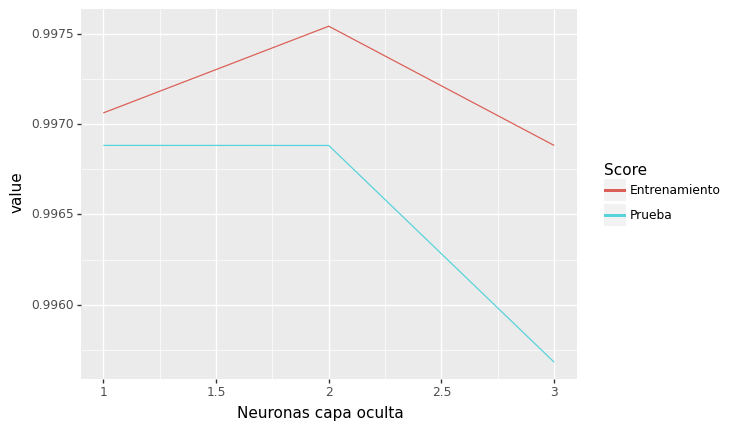

<ggplot: (8764418184810)>

In [149]:
g = pd.melt(df2,id_vars='Neuronas capa oculta')
g.rename(columns = {'variable':'Score'}, inplace = True) 
ggplot(g, aes(x='Neuronas capa oculta', y='value', color='Score')) +\
geom_line()

Con base en esto podemos pensar que con 1 o 2 neuronas deberíamos de tener el mejor rendimiento de la red neuronal, probaremos entonces ambas configuraciones con el set de validación para verificar esta información

# Entrenamiento modelos de red neuronal

In [0]:
m1 = MLPClassifier(activation='relu', 
                    hidden_layer_sizes=(1,), 
                    random_state=1, 
                    shuffle=True,
                    warm_start=True,
                    max_iter=10000)

m2 = MLPClassifier(activation='relu', 
                    hidden_layer_sizes=(2,), 
                    random_state=1, 
                    shuffle=True,
                    warm_start=True,
                    max_iter=10000)

m1.fit(X_train.toarray(), y_train)
y_validacion_pred1 = m1.predict(X_validacion.toarray())

m2.fit(X_train.toarray(), y_train)
y_validacion_pred2 = m2.predict(X_validacion.toarray())

# Evaluación de los modelos de Redes neuronales

Red neuronal con una neurona en la capa oculta: 

Accuracy Score : 0.9829181494661922
Report : 
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99      1222
        spam       0.96      0.91      0.93       183

    accuracy                           0.98      1405
   macro avg       0.97      0.95      0.96      1405
weighted avg       0.98      0.98      0.98      1405



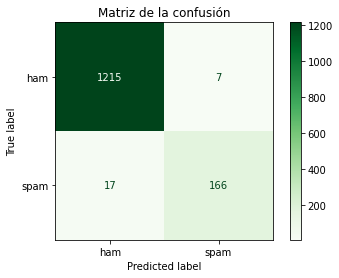

In [155]:
disp = plot_confusion_matrix(m1, X_validacion.toarray(), y_validacion,
                              display_labels=['ham','spam'],
                              cmap=plt.cm.Greens,
                              normalize=None, 
                              values_format = '.0f')
disp.ax_.set_title('Matriz de la confusión')

print("Red neuronal con una neurona en la capa oculta: \n")
print ('Accuracy Score :',accuracy_score(y_validacion, y_validacion_pred1)) 
print ('Report : ')
print (classification_report(y_validacion, y_validacion_pred1)) 

Red neuronal con dos neuronas en la capa oculta: 

Accuracy Score : 0.9836298932384342
Report : 
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1222
        spam       0.98      0.90      0.93       183

    accuracy                           0.98      1405
   macro avg       0.98      0.95      0.96      1405
weighted avg       0.98      0.98      0.98      1405



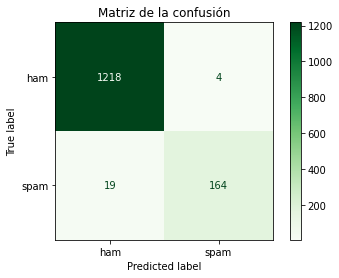

In [156]:
disp = plot_confusion_matrix(m2, X_validacion.toarray(), y_validacion,
                              display_labels=['ham','spam'],
                              cmap=plt.cm.Greens,
                              normalize=None, 
                              values_format = '.0f')
disp.ax_.set_title('Matriz de la confusión')

print("Red neuronal con dos neuronas en la capa oculta: \n")
print ('Accuracy Score :',accuracy_score(y_validacion, y_validacion_pred2)) 
print ('Report : ')
print (classification_report(y_validacion, y_validacion_pred2)) 

Podemos apreciar como con dos neuronas se puede clasificar un poco mejor los $ham$, y el modelo con solo una neurona puede clasificar solo un poco mejor el $spam$.

# Conclusión
Podemos apreciar como todos los modelos probados presentan un comportamiento similar, sin embargo si lo que queremos es clasificar la mayor cantidad de mensajes $ham$ correctamente, tenemos al segundo modelo de regresión logística como el ganador.
